# Cartesian Planning tutorial

We'll show cartesian planning on a panda robot.

If you want to see a simulation demo, check out the examples directory.

In [1]:
import numpy as np
import sys, os
import yaml
import trimesh
%matplotlib inline

pykin_path = os.path.dirname(os.getcwd())
sys.path.append(pykin_path)

from pykin.robots.single_arm import SingleArm
from pykin.kinematics.transform import Transform
from pykin.planners.cartesian_planner import CartesianPlanner
from pykin.collision.collision_manager import CollisionManager
from pykin.utils import plot_utils as plt
from pykin.objects.object_manager import ObjectManager

In [2]:
file_path = '../asset/urdf/panda/panda.urdf'
mesh_path = pykin_path+"/asset/urdf/panda/"
yaml_path = '../asset/config/panda_init_params.yaml'

In [3]:
robot = SingleArm(file_path, Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0]))
robot.setup_link_name("panda_link_0", "panda_right_hand")

with open(yaml_path) as f:
    controller_config = yaml.safe_load(f)
init_qpos = controller_config["init_qpos"]
fk = robot.forward_kin(np.array(init_qpos))

init_eef_pose = robot.get_eef_pose(fk)
goal_eef_pose = controller_config["goal_pos"]

### Apply to robot and object using CollisionManager

First, we show the cartesian planning demo when there are no objects.

In [4]:
c_manager = CollisionManager(mesh_path)
c_manager.setup_robot_collision(robot, fk)

milk_path = pykin_path+"/asset/objects/meshes/milk.stl"
milk_mesh = trimesh.load_mesh(milk_path)

obs = ObjectManager()
o_manager = CollisionManager(milk_path)

### Use CartesianPlanner

- n_step(int): Number of waypoints
- dimension(int): robot arm's dof
- damping: Value using DLS(Damped Least Squares)
- pos_sensitivity: Error reference value between the target pose and the current pose

Currently only "Linear" is supported current in waypoint_type.
- waypoint_type(str): Type of waypoint ex) "Linear", "Cubic", "Circular"

In [5]:
task_plan = CartesianPlanner(
    robot, 
    n_step=100,
    dimension=7,
    damping=0.03,
    pos_sensitivity=0.04,
    waypoint_type="Linear")

- joint_path : actual joint path  
- target_poses : target waypoint position

- resolution: Get number of waypoints * resolution

In [6]:
joint_path, target_poses = task_plan.get_joint_path(
    cur_q=init_qpos,
    goal_pose=goal_eef_pose,
    robot_col_manager=c_manager,
    object_col_manager=o_manager,
    resolution=1)

if joint_path is None and target_poses is None:
    print("Cannot Visulization Path")
    exit()

[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000151


WorkingTime[get_joint_path]: 0.2110 sec



In [7]:
joint_trajectory = []
eef_poses = []
for joint in joint_path:
    fk = robot.forward_kin(joint)
    joint_trajectory.append(fk)

print(f"Computed Goal Position : {joint_trajectory[-1][robot.eef_name].pose}")
print(f"Desired Goal position : {target_poses[-1]}")

Computed Goal Position : [ 2.99928297e-01 -5.70915989e-01  2.34257454e-01  2.69270088e-05
  9.97913021e-01  2.54093191e-04  6.45719534e-02]
Desired Goal position : [ 0.3        -0.57104895  0.23425477]


### Visualization Demo

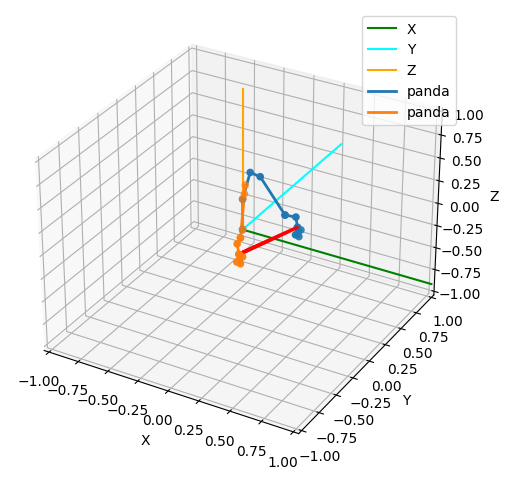

In [8]:

fig, ax = plt.init_3d_figure(figsize=(10,6), dpi= 100)

plt.plot_trajectories(ax, target_poses, size=3)
plt.plot_robot(
    robot,
    fk=joint_trajectory[0], 
    ax=ax,
    visible_text=False)
plt.plot_robot(
    robot, 
    fk=joint_trajectory[-1], 
    ax=ax, 
    visible_text=False,
    visible_basis=False)

plt.show_figure()

Next, we show the cartesian planning demo when there are objects.

In [9]:
name="milk1"
obs1_pos=[3.73820701e-01, -2.51826813e-01,  2.71833382e-01]
obs2_pos=[4.18720325e-01, -5.76662613e-02,  2.94687778e-01]
obs(name=name, gtype="mesh", gparam=milk_mesh, h_mat=Transform(pos=obs1_pos).h_mat)
obs(name="milk2", gtype="mesh", gparam=milk_mesh, h_mat=Transform(pos=obs2_pos).h_mat)

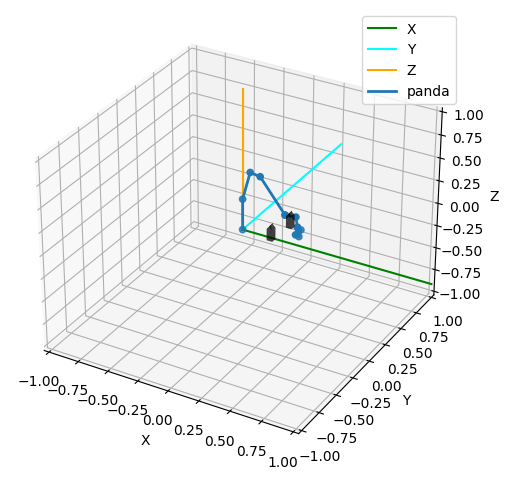

In [10]:

fig, ax = plt.init_3d_figure(figsize=(10,6), dpi= 100)
plt.plot_robot(
    robot,
    fk=joint_trajectory[0], 
    ax=ax,
    visible_text=False)

plt.plot_objects(ax, objects=obs)

plt.show_figure()

If there is an object while planning is in progress,  
you can see warning message that the position where the collision occurred and an error message that a conflict has occurred.

In [11]:
o_manager.setup_object_collision(obs)

joint_path, target_poses = task_plan.get_joint_path(
    cur_q=init_qpos,
    goal_pose=goal_eef_pose,
    robot_col_manager=c_manager,
    object_col_manager=o_manager,
    resolution=1)

[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[ERROR] [Cartesian Planner]: Failed Generate Path.. Collision may occur.
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('right_gripper', 'object_milk1')}
[WARNING] [Cartesian Planner]: 
	Collision Names : {('pa

{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('right_gripper', 'object_milk1')}
{('panda_link_7', 'object_milk1'), ('right_gripper', 'object_milk1')}
{('panda_link_7', 'object_milk1')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
{('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2'), ('right_gripper', 'object_milk2')}
{('panda_link_5', 'object_milk2')}
{('right_gripper', 'object_milk2'), ('panda_link_7', 'object_milk2'), ('panda_link_6', 'object_milk2')}
WorkingTime[get_joint_path]: 0.1245 sec

